In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{device}" " is available.")

cpu is available.


## Dataset preparation

In [3]:
## Load Imputation Dataframe
new_dataset = pd.read_pickle("dataset_processed.pkl")
new_dataset

,year,month,site_code,product_code,stock_distributed,imputation
timestamp,,,,,,
2016-01-01,2016,1,C2011,AS27000,114,False
2016-01-01,2016,1,C2131,AS27000,18,False
2016-01-01,2016,1,C2131,AS27139,3,False
2016-01-01,2016,1,C2131,AS27137,25,False
2016-01-01,2016,1,C2131,AS27138,0,False
...,...,...,...,...,...,...
2019-02-01,2019,2,C5066,AS46000,0,True
2019-03-01,2019,3,C5066,AS46000,0,True
2019-04-01,2019,4,C5066,AS46000,0,True


In [4]:
def get_sorted_data(df, site_id, product_id, plot_data=False):
    data = df['stock_distributed'][(df.site_code==site_id)&(new_dataset.product_code==product_id)].sort_index()
    x = data.index
    y = data.values
    col_label = f"{site_id}_{product_id}"
    response = {
        "site": site_id,
        "product": product_id,
        "col_label": col_label, 
        "dataframe": pd.DataFrame({'timestamp': x, col_label: y})
    }
    
    if plot_data:
        ## Plot dataset just to confirm
        plt.figure(figsize=(20,6))
        ax = plt.subplot(111)
        ax.plot(x,y, color='darkorange', marker='o', linewidth=3)
        ax.title.set_text(f"Site {site_id} - Product {product_id}")
        ax.set_ylim([-10, max(y) + 10])
        #ax.xaxis_date()
        ax.set_xlim([x.min(), x.max()])
        plt.grid()
        plt.show()
    return response  

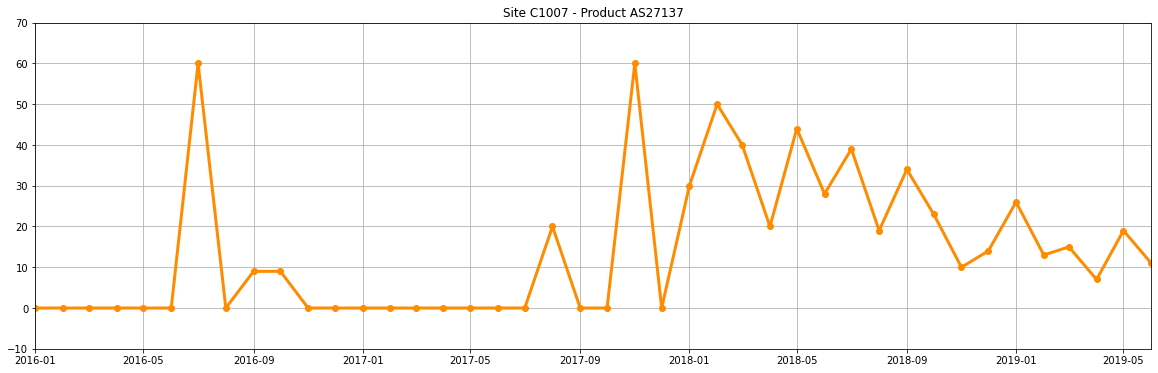

In [5]:
d = get_sorted_data(new_dataset, 'C1007', 'AS27137', plot_data=True)

In [6]:
data_timestamp=d['dataframe']['timestamp']

In [7]:
all_products = sorted(list(new_dataset.product_code.unique()))
all_sites = sorted(list(new_dataset.site_code.unique()))

In [8]:
generate_hts_dataset = False
if generate_hts_dataset:
    full_df = pd.DataFrame({'timestamp': data_timestamp})
    for s in all_sites:
        for p in all_products:
            d = get_sorted_data(new_dataset, s, p, plot_data=True)
            print(d['dataframe'])
            print(d['col_label'])
            full_df[d['col_label']]=d['dataframe'][d['col_label']]
    full_df.to_pickle("dataset_multilevel.pkl")

In [9]:
len(all_products), len(all_sites), len(all_products)*len(all_sites)

(11, 155, 1705)

In [10]:
new_dataset = pd.read_pickle("dataset_multilevel.pkl")
new_dataset.head()

,timestamp,C1004_AS17005,C1004_AS21126,C1004_AS27000,C1004_AS27132,C1004_AS27133,C1004_AS27134,C1004_AS27137,C1004_AS27138,C1004_AS27139,...,C5066_AS21126,C5066_AS27000,C5066_AS27132,C5066_AS27133,C5066_AS27134,C5066_AS27137,C5066_AS27138,C5066_AS27139,C5066_AS42018,C5066_AS46000
0,2016-01-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2016-02-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2016-03-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2016-05-01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
new_dataset.index= new_dataset.timestamp
new_dataset.drop(columns={'timestamp'},inplace=True)

In [12]:
new_dataset.head()

,C1004_AS17005,C1004_AS21126,C1004_AS27000,C1004_AS27132,C1004_AS27133,C1004_AS27134,C1004_AS27137,C1004_AS27138,C1004_AS27139,C1004_AS42018,...,C5066_AS21126,C5066_AS27000,C5066_AS27132,C5066_AS27133,C5066_AS27134,C5066_AS27137,C5066_AS27138,C5066_AS27139,C5066_AS42018,C5066_AS46000
timestamp,,,,,,,,,,,,,,,,,,,,,
2016-01-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-02-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-03-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-04-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-05-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## DeepAR with GluonTS

In [13]:
from gluonts.dataset import common
from gluonts.model import deepar
from gluonts.mx.trainer import Trainer
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deepvar import DeepVAREstimator
from gluonts.dataset.common import ListDataset
from gluonts.evaluation.backtest import make_evaluation_predictions
import pandas as pd
from itertools import islice

In [116]:
all_cols=list(new_dataset.columns)
all_cols

['C1004_AS17005',
 'C1004_AS21126',
 'C1004_AS27000',
 'C1004_AS27132',
 'C1004_AS27133',
 'C1004_AS27134',
 'C1004_AS27137',
 'C1004_AS27138',
 'C1004_AS27139',
 'C1004_AS42018',
 'C1004_AS46000',
 'C1007_AS17005',
 'C1007_AS21126',
 'C1007_AS27000',
 'C1007_AS27132',
 'C1007_AS27133',
 'C1007_AS27134',
 'C1007_AS27137',
 'C1007_AS27138',
 'C1007_AS27139',
 'C1007_AS42018',
 'C1007_AS46000',
 'C1008_AS17005',
 'C1008_AS21126',
 'C1008_AS27000',
 'C1008_AS27132',
 'C1008_AS27133',
 'C1008_AS27134',
 'C1008_AS27137',
 'C1008_AS27138',
 'C1008_AS27139',
 'C1008_AS42018',
 'C1008_AS46000',
 'C1009_AS17005',
 'C1009_AS21126',
 'C1009_AS27000',
 'C1009_AS27132',
 'C1009_AS27133',
 'C1009_AS27134',
 'C1009_AS27137',
 'C1009_AS27138',
 'C1009_AS27139',
 'C1009_AS42018',
 'C1009_AS46000',
 'C1010_AS17005',
 'C1010_AS21126',
 'C1010_AS27000',
 'C1010_AS27132',
 'C1010_AS27133',
 'C1010_AS27134',
 'C1010_AS27137',
 'C1010_AS27138',
 'C1010_AS27139',
 'C1010_AS42018',
 'C1010_AS46000',
 'C1011_AS

In [117]:
## Convert Dataset to Gluon Format
time_series_dicts = []
for c in new_dataset.columns:
    time_series=np.array(new_dataset[c])
    time_series_dicts.append({"target": time_series, "start": new_dataset.index[0]})
training_data_uni = ListDataset(time_series_dicts, freq='M')
training_data_uni.list_data

[{'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'start': Timestamp('2016-01-01 00:00:00')},
 {'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
  'start': Timestamp('2016-01-01 00:00:00')},
 {'target': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  7, 44, 13, 16, 32, 30, 34,  5, 61, 22, 26, 61,  0, 40, 55,
         17, 60, 13, 19, 19, 43, 30, 21]),
  'start': Timestamp('2016-01-01 00:00:00')},
 {'target': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0, 10,  0,  0,  2,  8,  0,  3,  2,  0,  0,  6,  7,  0,  0,
          3,  9,  0,  0,  0,  0,  2,  1]),
  'start': Timestamp('2016-01-01 00:00:00')},
 {'target': array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
   

In [118]:
len(training_data_uni.list_data)

1705

In [119]:
freq_preds = 'M'
pred_lenght = 3
super_trainer = Trainer(learning_rate=1e-3,
                        batch_size = 8,
                        minimum_learning_rate=5e-5,
                        epochs=30
                       )

In [120]:
estimator_uni = DeepAREstimator(freq=freq_preds, 
                            prediction_length=pred_lenght, 
                            trainer=super_trainer,
                            num_layers=2,
                            num_cells=50)
predictor_uni = estimator_uni.train(training_data=training_data_uni)

100%|██████████| 50/50 [00:00<00:00, 78.21it/s, epoch=30/30, avg_epoch_loss=0.583]


In [122]:
def get_preds_uni(col_num):
    inference_data = ListDataset([training_data_uni.list_data[col_num]], freq='M')
    preds_uni = next(predictor_uni.predict(inference_data, num_samples=10))
    mean_predictions_uni = np.mean(preds_uni.samples, axis=0).T
    return mean_predictions_uni

In [125]:
get_preds_uni(0)[0]

2.3036592e-10

In [127]:
preds_uni = pd.DataFrame(columns=['ID','prediction'])
for i, c in enumerate(all_cols):
    site, product = c.split("_")
    all_preds_uni = get_preds_uni(i)
    rows = [{
        "ID": f"2019 X 7 X {site} X {product}",
         "prediction": round(max(all_preds_uni[0],0))
    },
    {
        "ID": f"2019 X 8 X {site} X {product}",
         "prediction": round(max(all_preds_uni[1],0))
    },
    {
        "ID": f"2019 X 9 X {site} X {product}",
         "prediction": round(max(all_preds_uni[2],0))
    }]
    preds_uni = preds_uni.append(rows)

In [128]:
preds_uni = preds_uni.reset_index(drop=True)

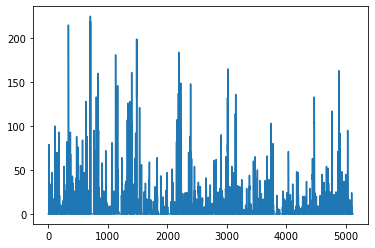

In [130]:
plt.plot(preds_uni['prediction'])

In [131]:
preds.to_csv("DeepAR_Univariate_Submission.csv")

## Multivariate Model

In [132]:
indices = new_dataset.index
target = new_dataset.to_numpy().T

freq_preds = "M"
dataset = ListDataset([{"start": indices[0], "target": target}], freq=freq_preds, one_dim_target=False)
dataset.list_data

[{'start': Timestamp('2016-01-01 00:00:00'),
  'target': array([[ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ..., 43, 30, 21],
         ...,
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0],
         [ 0,  0,  0, ...,  0,  0,  0]])}]

In [133]:
target_dim = target.shape[0] 
pred_lenght = 3
multi_trainer = Trainer(learning_rate=1e-3,
                        batch_size = 8,
                        minimum_learning_rate=5e-5,
                        epochs=15
                       )

In [134]:
estimator = DeepVAREstimator(target_dim=target_dim,
                             prediction_length=pred_lenght,
                             context_length = 20,
                             freq=freq_preds,
                             trainer=multi_trainer) 

predictor = estimator.train(dataset)

/Users/rsilvei/.pyenv/versions/3.7.2/envs/torch/lib/python3.7/site-packages/gluonts/model/deepvar/_estimator.py:88: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  values = getattr(index, self.freq)
100%|██████████| 50/50 [00:43<00:00,  1.14it/s, epoch=15/15, avg_epoch_loss=4.79e+18]


In [135]:
prediction = next(predictor.predict(dataset))
mean_predictions = np.mean(prediction.samples, axis=0).T

In [136]:
preds = pd.DataFrame(columns=['ID','prediction'])
for i, c in enumerate(all_cols):
    site, product = c.split("_")
    all_preds = mean_predictions[i]
    rows = [{
        "ID": f"2019 X 7 X {site} X {product}",
         "prediction": round(max(all_preds[0],0))
    },
    {
        "ID": f"2019 X 8 X {site} X {product}",
         "prediction": round(max(all_preds[1],0))
    },
    {
        "ID": f"2019 X 9 X {site} X {product}",
         "prediction": round(max(all_preds[2],0))
    }]
    preds = preds.append(rows)

In [137]:
preds = preds.reset_index(drop=True)

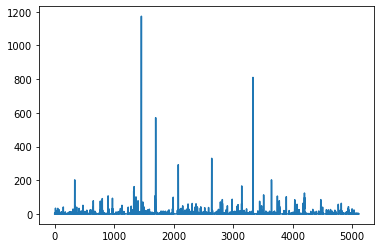

In [138]:
plt.plot(preds['prediction'])

In [139]:
preds.to_csv("DeepAR_Multivariate_Submission.csv")

## Sources

- [Multiple Time Series](https://github.com/awslabs/gluon-ts/issues/1095)
- [Forecasting](https://github.com/awslabs/gluon-ts/issues/763)
- https://github.com/awslabs/gluon-ts
- https://ts.gluon.ai/
- https://aws.amazon.com/blogs/machine-learning/creating-neural-time-series-models-with-gluon-time-series/